# <center>地方棋牌高价值用户分析框架</center>
> 目录：
1. 分析的目的
2. 高价值用户的定义和分类
3. 分析过程、方法
4. 输出内容

## 分析的目的
高价值用户数量少，但是贡献了绝大部分的收入，不管这些用户是否已经流失，我们都能从他们曾经的行为挖掘出有价值的信息  
* 高价值用户的来源：在用户周期一定的情况下，如何获取到更多高价值的用户是相当有价值的；而且对于以后扩展其他游戏业务也有很大的帮助
* 高价值用户的玩牌习惯：有助于我们改善游戏设计和体验
* 高价值用户的付费习惯：可以帮助我们更好地设计游戏的付费流程、商品等

## 高价值用户的定义
参考RFM模型，棋牌游戏的RFM模型为：
> 
R：Recent，近期，表示近期有活跃的用户  
F：Frequency，频率，比如一周或一个月玩牌频率，也可以是付费频率  
M：Money，付费，总付费额  

由于我们这次是讨论的曾经的所有高价值用户，所以忽略Recent  
主要用付费总额、付费次数、玩牌天数等指标  

付费总额和付费次数是最重要的衡量指标，但是不同的付费目的会催生出不同的人群，长期玩牌但是不付费的用户也不是没有价值，这里我们再划分一下：   
如果将付费总额和付费次数分开来的话，三个指标会形成一个三维划分，维度太多（有27个），这里我们将付费总额和付费次数根据算法统一为一个付费分值  

##### 假设付费总额为X，付费次数为Y，付费分值为Z，则计算公式为：  
<center>$ Z=αX+(1-α)Y $   <span style="padding-left:20px">(α为[0,1]之间的常数)</span></center>
我们暂时设定α=0.7  
但是由于付费总额和付费次数也不是同一个单位的，这里我们需要先对两个指标进行一下归一化处理：  
归一化有三种办法，分别为：  
>    
* #### min-max标准化 $$ X = \frac{x-x_{min}}{x_{max}-x_{min}}$$
* #### Z-Score标准化 $$ X = \frac{x-μ}σ$$
* #### 第三种办法是我们自己想出来的，暂且叫面积标准化好了，原理如下图：
<img src="./suanfa.png" />
每个区间代表一个分值，用户落在哪个区间就是哪个分值  
这里只画了10个区间，实际计算可以分成100等分或者任意等分  
如果一个人落在了多个区间，那么取最小区间值（向下取整）

#####  <span style="color:red"> min-max和z-score方法对于计算量要求高，min-max容易受极值影响，z-score则需要计算标准差和均值，这里我们采用了自己研发的面积标准化方法</span>
python代码为:  

```python
    sum(pay_sum_usd) over(partition by fgamefsk, fplatformfsk order by pay_sum_usd desc nulls last rows between unbounded preceding and current row) as pay_sum_usd_position  
    sum(pay_sum_usd) over(partition by fgamefsk, fplatformfsk) as pay_sum_usd_area  
    sum(pay_count) over(partition by fgamefsk, fplatformfsk order by pay_count desc nulls last rows between unbounded preceding and current row) as pay_count_position  
    sum(pay_count) over(partition by fgamefsk, fplatformfsk) as pay_count_area  
    coalesce(100 - floor(pay_sum_usd_position * 80 / pay_sum_usd_area +pay_count_position * 20 / pay_count_area),0) as pay_passion
```
#### 玩牌活跃度也可以根据玩牌时长和玩牌局数来计算，方法和付费一致，α取0.5，也就是时长和局数各占一半
python代码为：
```python
    sum(basic_duration) over(partition by fgamefsk, fplatformfsk order by basic_duration desc nulls last rows between unbounded preceding and current row) as play_duration_position
    sum(basic_duration) over(partition by fgamefsk, fplatformfsk) as play_duration_area
    sum(play_innings) over(partition by fgamefsk, fplatformfsk order by play_innings desc nulls last rows between unbounded preceding and current row) as play_innings_position
    sum(play_innings) over(partition by fgamefsk, fplatformfsk) as play_innings_area
coalesce(100 -floor(play_duration_position * 50 / play_duration_area +play_innings_position * 50 / play_innings_area),0) as play_passion
```

从付费分值来看，分为：  
- 付费高、付费低、不付费  
由于不付费的人群占总比例的

从玩牌活跃度来看，分为：
- 活跃高、活跃低、不活跃  

#### 组合两个指标，用户价值可以分为下面九类：


<img src="./pay-play.png" style="float:left;">

##### <p style="clear:both">1为价值最高，9最低</p>

## 建立用户价值表
python代码为：
```python
CREATE TABLE veda.fiona_dfqp_user_score AS
SELECT mid,
       fplatformname,
       coalesce(100-floor(play_duration_position*50/play_duration_area+play_innings_position*50/play_innings_area)) AS play_score,
       coalesce(100-floor(pay_sum_position*80/pay_sum_area+pay_count_position*20/pay_count_area)) AS pay_score
FROM
  (SELECT sum(play_duration) over(partition BY fplatformfsk
                                  ORDER BY play_duration DESC nulls LAST ROWS BETWEEN unbounded preceding AND CURRENT ROW) AS play_duration_position,
          sum(play_duration) over(partition BY fplatformfsk) AS play_duration_area,
          sum(total_innings) over(partition BY fplatformfsk
                                  ORDER BY total_innings DESC nulls LAST ROWS BETWEEN unbounded preceding AND CURRENT ROW) AS play_innings_position,
          sum(total_innings) over(partition BY fplatformfsk) AS play_innings_area,
          sum(pay_sum) over(partition BY fplatformfsk
                            ORDER BY pay_sum DESC nulls LAST ROWS BETWEEN unbounded preceding AND CURRENT ROW) AS pay_sum_position,
          sum(pay_sum) over(partition BY fplatformfsk) AS pay_sum_area,
          sum(pay_count) over(partition BY fplatformfsk
                              ORDER BY pay_count DESC nulls LAST ROWS BETWEEN unbounded preceding AND CURRENT ROW) AS pay_count_position,
          sum(pay_count) over(partition BY fplatformfsk) AS pay_count_area,
          mid,
          fplatformname
   FROM veda.dfqp_user_portrait) a
```
<img src='./pay-playcore.png' />
#### 依据分值分布情况，决定将分类划分为：
高|中|低
:----:|:---:|:---:
60~100|10~59|0~9

按照这个标准，建立用户价值标签表
python代码为：
```python
SELECT mid,
       fplatformname,
       CASE
           WHEN play_score >=0
                AND play_score <=9
                AND pay_score >=0
                AND pay_score <=9 THEN label_score = 9
           WHEN play_score >=0
                AND play_score <=9
                AND pay_score >=10
                AND pay_score <=59 THEN label_score = 7
           WHEN play_score >=0
                AND play_score <=9
                AND pay_score >=60
                AND pay_score <=100 THEN label_score = 4
           WHEN play_score >=10
                AND play_score <=59
                AND pay_score >=0
                AND pay_score <=9 THEN label_score = 8
           WHEN play_score >=10
                AND play_score <=59
                AND pay_score >=10
                AND pay_score <=59 THEN label_score = 5
           WHEN play_score >=10
                AND play_score <=59
                AND pay_score >=60
                AND pay_score <=100 THEN label_score = 2
           WHEN play_score >=60
                AND play_score <= 100
                AND pay_score >=0
                AND pay_score <=9 THEN label_score = 6
           WHEN play_score >=60
                AND play_score <= 100
                AND pay_score >=10
                AND pay_score <=59 THEN label_score = 3
           WHEN play_score >=60
                AND play_score <= 100
                AND pay_score >=60
                AND pay_score <=100 THEN label_score = 1
       END as label,
       play_score,
       pay_score
FROM veda.fiona_dfqp_user_score_1
```

## 筛选用户注册渠道字段
主要的字段有：
* 地理位置信息
    * IP
    * 城市
    * 经度
    * 纬度
* 渠道信息
    * 渠道ID
    * 广告ID
    * 来源路径
    * 代理商
* 终端
    * 设备型号
    * 设备分辨率
    * 设备码
    * 设备操作系统
    * 终端名称
    * 网络运营商
    * 联网方式
* 其他注册信息
    * 注册时间（到秒）
    * 性别
    * 手机号
    * 邮箱
    * 身份证号码

建立用户渠道表：
```python
CREATE TABLE veda.fiona_dfqp_user_signupinfo_1 AS
SELECT a.mid,
       b.fplatformname,
       b.fhallname,
       a.label_score,
       b.signup_time,
       b.signup_ip,
       b.signup_ip_city,
       b.signup_channel_code,
       b.signup_device_type,
       b.signup_device_pixel,
       b.signup_os,
       b.fterminaltypename,
       b.latest_operator,
       b.gender,
       b.phone_number,
       b.email,
       b.id_card_number
FROM veda.fiona_dfqp_user_label a
RIGHT JOIN veda.dfqp_user_portrait b ON a.mid = b.mid
```
## 抽取数据进行分析

In [3]:
%matplotlib inline 
#有了matplotlib inline 就可以省掉plt.show()了
%load_ext autoreload
%autoreload 2

from __future__ import division
from imports import *
#import pylab #使用pylab模式，可以直接使用numpy、pandas和绘图，而不需要再次引入,会配置为使用你所指定的matplotlib gui后端，还会提供一种更接近于matlab的界面
#%pylab
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle code</button>""", raw=True)
# 允许多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Toggle code

In [7]:
# 导入数据
path = './csvs/dfqp_label_login.csv'
file1 = pd.read_csv(path)
file1.head(10)
file1.describe()
file1.groupby('fiona_dfqp_user_signupinfo_1.label_score').size()

,fiona_dfqp_user_signupinfo_1.mid,fiona_dfqp_user_signupinfo_1.fplatformname,fiona_dfqp_user_signupinfo_1.fhallname,fiona_dfqp_user_signupinfo_1.label_score,fiona_dfqp_user_signupinfo_1.signup_time,fiona_dfqp_user_signupinfo_1.signup_ip,fiona_dfqp_user_signupinfo_1.signup_ip_city,fiona_dfqp_user_signupinfo_1.signup_channel_code,fiona_dfqp_user_signupinfo_1.signup_device_type,fiona_dfqp_user_signupinfo_1.signup_device_pixel,fiona_dfqp_user_signupinfo_1.signup_os,fiona_dfqp_user_signupinfo_1.fterminaltypename,fiona_dfqp_user_signupinfo_1.latest_operator,fiona_dfqp_user_signupinfo_1.gender,fiona_dfqp_user_signupinfo_1.phone_number,fiona_dfqp_user_signupinfo_1.email,fiona_dfqp_user_signupinfo_1.id_card_number
0,16629434,辽宁,营口大厅,9,2017-06-30 10:00:23,175.167.152.54,沈阳,114972,CUN-AL00,1196*720,android_5.1,ANDROID,中国联通,未定义,1.307943e+10,NaN,NaN
1,15132035,云南,昆明大厅,9,2017-06-13 14:08:52,14.119.83.70,广州,114971,ZTE,800*500,android_5.1.1,ANDROID,中国移动,未定义,NaN,NaN,NaN
2,20843744,四川,宜宾大厅,9,2018-04-27 07:33:54,223.104.214.33,NaN,114152,PACT00,1920*1080,android_8.1.0,ANDROID,中国移动,男,NaN,NaN,NaN
3,16648697,其他,四国军棋,8,2017-06-30 18:02:11,117.28.77.34,南平,114852,vivo Y31A,960*540,android_5.1.1,ANDROID,中国电信,未定义,NaN,NaN,NaN
4,20513796,云南,曲靖大厅,5,2018-03-07 18:39:38,117.136.16.85,NaN,115086,vivo X9i,1920*1080,android_7.1.1,ANDROID,中国移动,男,NaN,NaN,530328199604152118
5,13151471,云南,昆明大厅,9,2017-06-01 22:12:06,139.206.182.76,资阳,114971,SM-A8000,800*500,android_5.1.1,ANDROID,中国移动,未定义,NaN,NaN,NaN
6,1329344,四川,宜宾大厅,9,2016-05-20 01:39:10,111.20.241.223,西安,114152,R8107,1920*1080,android_4.4.4,ANDROID,中国移动,未定义,NaN,NaN,NaN
7,18380303,四川,宜宾大厅,8,2017-08-31 20:42:10,175.154.41.44,宜宾,114152,OPPO A59s,1280*720,android_5.1,ANDROID,中国电信,男,NaN,NaN,NaN
8,13131225,云南,昆明大厅,9,2017-06-01 18:10:59,139.206.182.49,资阳,114971,HTC,800*500,android_5.1.1,ANDROID,中国移动,未定义,NaN,NaN,NaN
9,1077492,四川,宜宾大厅,9,2016-04-05 23:19:19,182.133.192.123,宜宾,113819,Hisense M20-T,854*480,android_4.4.4,ANDROID,中国电信,未定义,NaN,NaN,NaN


,fiona_dfqp_user_signupinfo_1.mid,fiona_dfqp_user_signupinfo_1.label_score,fiona_dfqp_user_signupinfo_1.signup_channel_code,fiona_dfqp_user_signupinfo_1.phone_number
count,1.000000e+05,100000.000000,100000.000000,6.279000e+03
mean,4.111476e+07,8.595990,114312.111660,1.605589e+10
std,1.683744e+08,1.035701,6214.718936,1.919644e+09
min,3.190240e+05,1.000000,-1.000000,1.300174e+10
25%,6.891181e+06,9.000000,114595.000000,1.398894e+10
50%,1.261519e+07,9.000000,114971.000000,1.576998e+10
75%,1.687054e+07,9.000000,115125.000000,1.818771e+10
max,1.003022e+09,9.000000,115401.000000,1.998830e+10


fiona_dfqp_user_signupinfo_1.label_score
1      111
2      117
3      674
4        6
5     3328
6     1582
7     1145
8    14272
9    78765
dtype: int64

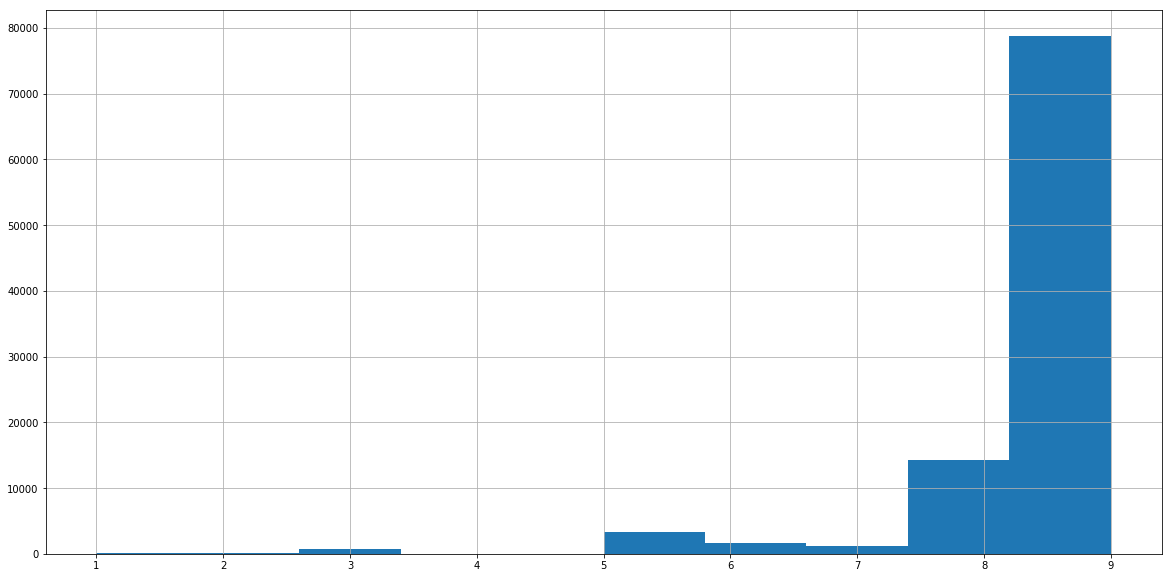

In [12]:
# 可视化看分布
from IPython.core.pylabtools import figsize 
figsize(20,10)
file1['fiona_dfqp_user_signupinfo_1.label_score'].hist(xlabelsize=10)

In [23]:

#file1['fiona_dfqp_user_signupinfo_1.signup_ip'] =file1['fiona_dfqp_user_signupinfo_1.signup_ip'].astype('str')
#file1.dtypes
pd.get_dummies(file1['fiona_dfqp_user_signupinfo_1.latest_operator'])
file1.head(10)

,中国电信,中国移动,中国联通
0,0,0,1
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,1,0,0
8,0,1,0
9,1,0,0


,fiona_dfqp_user_signupinfo_1.mid,fiona_dfqp_user_signupinfo_1.fplatformname,fiona_dfqp_user_signupinfo_1.fhallname,fiona_dfqp_user_signupinfo_1.label_score,fiona_dfqp_user_signupinfo_1.signup_time,fiona_dfqp_user_signupinfo_1.signup_ip,fiona_dfqp_user_signupinfo_1.signup_ip_city,fiona_dfqp_user_signupinfo_1.signup_channel_code,fiona_dfqp_user_signupinfo_1.signup_device_type,fiona_dfqp_user_signupinfo_1.signup_device_pixel,fiona_dfqp_user_signupinfo_1.signup_os,fiona_dfqp_user_signupinfo_1.fterminaltypename,fiona_dfqp_user_signupinfo_1.latest_operator,fiona_dfqp_user_signupinfo_1.gender,fiona_dfqp_user_signupinfo_1.phone_number,fiona_dfqp_user_signupinfo_1.email,fiona_dfqp_user_signupinfo_1.id_card_number
0,16629434,辽宁,营口大厅,9,2017-06-30 10:00:23,175.167.152.54,沈阳,114972,CUN-AL00,1196*720,android_5.1,ANDROID,中国联通,未定义,1.307943e+10,NaN,NaN
1,15132035,云南,昆明大厅,9,2017-06-13 14:08:52,14.119.83.70,广州,114971,ZTE,800*500,android_5.1.1,ANDROID,中国移动,未定义,NaN,NaN,NaN
2,20843744,四川,宜宾大厅,9,2018-04-27 07:33:54,223.104.214.33,NaN,114152,PACT00,1920*1080,android_8.1.0,ANDROID,中国移动,男,NaN,NaN,NaN
3,16648697,其他,四国军棋,8,2017-06-30 18:02:11,117.28.77.34,南平,114852,vivo Y31A,960*540,android_5.1.1,ANDROID,中国电信,未定义,NaN,NaN,NaN
4,20513796,云南,曲靖大厅,5,2018-03-07 18:39:38,117.136.16.85,NaN,115086,vivo X9i,1920*1080,android_7.1.1,ANDROID,中国移动,男,NaN,NaN,530328199604152118
5,13151471,云南,昆明大厅,9,2017-06-01 22:12:06,139.206.182.76,资阳,114971,SM-A8000,800*500,android_5.1.1,ANDROID,中国移动,未定义,NaN,NaN,NaN
6,1329344,四川,宜宾大厅,9,2016-05-20 01:39:10,111.20.241.223,西安,114152,R8107,1920*1080,android_4.4.4,ANDROID,中国移动,未定义,NaN,NaN,NaN
7,18380303,四川,宜宾大厅,8,2017-08-31 20:42:10,175.154.41.44,宜宾,114152,OPPO A59s,1280*720,android_5.1,ANDROID,中国电信,男,NaN,NaN,NaN
8,13131225,云南,昆明大厅,9,2017-06-01 18:10:59,139.206.182.49,资阳,114971,HTC,800*500,android_5.1.1,ANDROID,中国移动,未定义,NaN,NaN,NaN
9,1077492,四川,宜宾大厅,9,2016-04-05 23:19:19,182.133.192.123,宜宾,113819,Hisense M20-T,854*480,android_4.4.4,ANDROID,中国电信,未定义,NaN,NaN,NaN
